# Linear Classifier with Polynominal Basis Expansion

Imports and Helper Functions
---

In [3]:
%matplotlib inline
from ipywidgets import interactive_output
import ipywidgets as widgets
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import datasets as skdatasets

## Data Set Generation

In [4]:
N = 100
datasets={}

X = np.vstack((2.5*np.random.randn(int(N/2),2)-5, (2.5*np.random.randn(int(N/2),2)+5)))
Y = np.hstack((-1*np.ones((int(N/2))), np.ones((int(N/2))))) 

ind = np.random.permutation(range(N))

datasets["Dataset 1"]=(X[ind,:],Y[ind])


# generate points for the four quadrants
n_4 = int(N / 4)
x1 = np.random.normal(loc=[5, 5], scale=2, size=(n_4, 2))
x2 = np.random.normal(loc=[-5, 5], scale=2, size=(n_4, 2))
x3 = np.random.normal(loc=[-5, -5], scale=2, size=(n_4, 2))
x4 = np.random.normal(loc=[5, -5], scale=2, size=(n_4, 2))

# make quadrant 1 and 3 as -1 label, 2 and 4 as +1 label.
X = np.vstack((x1, x3, x2, x4))
y = np.hstack((-1 * np.ones(n_4 * 2), np.ones(n_4 * 2)))

ind = np.random.permutation(range(N))  # indices to shuffle the data.
X = X[ind, :]
y = y[ind]

datasets["Dataset 2"] = (X, y)


X, y = skdatasets.make_circles(n_samples=N, shuffle=True, noise=0.08, random_state=None, factor=0.4)
y[(y == 0)] = -1

# Rescale the data to [-9, 9] range.
X[:, 0] = (X[:, 0] + 1) * 18 / 2 + (-9)
X[:, 1] = (X[:, 1] + 1) * 18 / 2 + (-9)

datasets["Dataset 3"] = (X, y)


X, y = skdatasets.make_moons(n_samples=N, shuffle=True, noise=0.1, random_state=None)
y[(y == 0)] = -1

# Rescale the data to [-9, 9] range.
old_min, old_max = np.min(X[:, 0]), np.max(X[:, 0])
old_range = old_max - old_min
X[:, 0] = (X[:, 0] - old_min) * 18 / old_range + (-9)

old_min, old_max = np.min(X[:, 1]), np.max(X[:, 1])
old_range = old_max - old_min
X[:, 1] = (X[:, 1] - old_min) * 18 / old_range + (-9)

datasets["Dataset 4"] = X, y

## Define Prediction, Loss, and Learning Function

In [5]:
def phi(X,degree):
    phiX = []
    for d in range(degree):
        p1=np.arange(d+2).reshape((1,d+2))
        p0=np.fliplr(p1)
        phiX.append((X[:,[0]]**p0)*(X[:,[1]]**p1)/(10**d))
    return(np.hstack(phiX))
                  
def discriminant(X,w,b,degree):
    Yhat = phi(X,degree).dot(w) + b
    return Yhat

def classification_error(Y,Yhat):
    #Compute the empirical risk given Y and Yhat
    Y=Y.flatten()
    Yhat=Yhat.flatten()
    R = np.mean(Y*Yhat<0)
    return(R)

def fit(X,Y,degree,log_lambda):
    lam = np.exp(log_lambda)
    C   = 1/lam
    clf = linear_model.LogisticRegression(C=C,max_iter=5000)
    clf.fit(phi(X,degree),Y)
    w=clf.coef_
    w=w.reshape((w.size,1))
    b=clf.intercept_
    return(w,b)


## Interaction Functions and UI

In [15]:
def plot_model(w=np.zeros((5,1)), dataset=None, N=0, learn=False, degree=1,log_lambda=0):

    fig = plt.figure(1,figsize=(14,6))
    plt.rcParams.update({'font.size': 12})
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    R=0
    if(dataset is not None and N>0):
        X,Y=datasets[dataset]
        X=X[:N]
        Y=Y[:N]
    
        ind1=(Y==1)
        indm1=(Y==-1)
        ax1.plot(X[ind1,0],X[ind1,1],'bs')
        ax1.plot(X[indm1,0],X[indm1,1],'rs')
        
        ax2.scatter(X[ind1,0],X[ind1,1],0*X[ind1,1],'s',color='b')
        ax2.scatter(X[indm1,0],X[indm1,1],0*X[indm1,1],'s',color='r')
        
        if(learn and np.sum(ind1)>0 and np.sum(indm1)>0):
            w,b=fit(X,Y,degree,log_lambda)
            Yhat = discriminant(X,w,b,degree)
            R = classification_error(Y,Yhat)
    
            gx1, gx2 = np.meshgrid(np.arange(-10, 10,1/10.0 ),np.arange(-10, 10,1/10.0))
            gx1l = gx1.flatten()
            gx2l = gx2.flatten()
            gx   = np.vstack((gx1l,gx2l)).T       
            gyhat = discriminant(gx,w,b,degree)  
            gyhat = gyhat.reshape(gx1.shape)

            if(not all(gyhat.flatten()==0)):
                contours = ax1.contour(gx1, gx2, gyhat, levels=[0], linewidths=2,colors=["k"]) 
                img=ax1.imshow(gyhat, interpolation='nearest',extent=(-10, 10, -10, 10), aspect='auto', origin='lower', cmap=plt.cm.bwr_r, alpha=0.25, vmin=-10,vmax=10)
                #ax1.set_vlim(-10,10)
                plt.colorbar(img,ax=ax1)
                
                ax2.plot_surface(gx1, gx2, gyhat, rstride=10, cstride=10,cmap=plt.cm.bwr_r, edgecolor='k',edgewidth=0.05,alpha=0.5)
    
    ax1.set_xlim(-10,10)
    ax1.set_ylim(-10,10)
    ax1.set_title("Error Rate: %.2f"%(R))
    ax1.set_xlabel("X0")
    ax1.set_ylabel("X1")
    ax1.grid(True)
    ax1.legend(["Class 1","Class -1"],loc='upper left')
    
    ax2.set_xlim(-10,10)
    ax2.set_ylim(-10,10)
    ax1.set_xlabel("X0")
    ax1.set_ylabel("X1")    
    ax2.set_zlabel("g(x)")
    
    plt.show()

wd=widgets.Dropdown(options=[("Dataset 1"),("Dataset 2"),("Dataset 3"),("Dataset 4")],description="Dataset")
wn=widgets.IntSlider(value=0,min=0,max=N,step=1,description="N",continuous_update=False)
wdeg=widgets.IntSlider(value=1,min=1,max=4,step=1,description="Degree",continuous_update=False) 
wlambda = widgets.FloatSlider(value=-10,min=-10,max=10.0,step=1,description='log10(lam)',continuous_update=False,readout=True,readout_format='.2f',)
wl = widgets.Checkbox(value=False, description="Learn")

out = interactive_output(plot_model, {"dataset":wd,"N":wn,"degree":wdeg,"log_lambda":wlambda,"learn":wl});
out.layout.height = '400px'
box1=widgets.HBox([wd,wn,wl])
box2=widgets.HBox([wdeg,wlambda])
ui=widgets.VBox([box1,box2]);


## Linear Classifier Demo with Polynomial Basis Expansion

Output(layout=Layout(height='400px'), outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure…

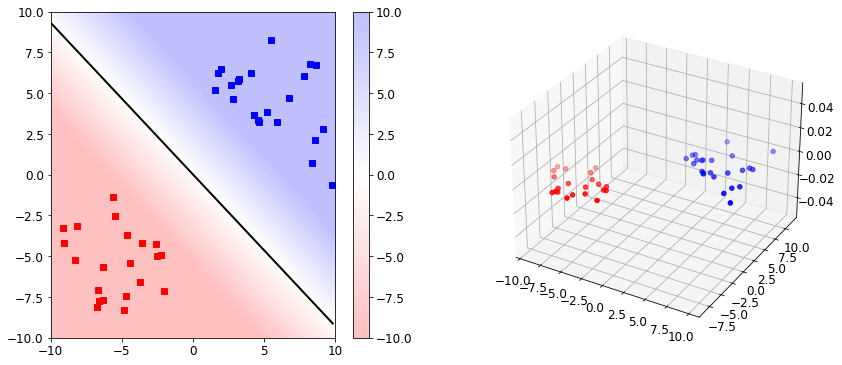

In [16]:
display(out,ui)